# 📈 Time Series Analysis

### Sobre el proyecto: 

Predicción de ventas. Con un total de 421,570 records de venta (143 semanas) de 45 tiendas que van desde el 05/Feb/10 - 26/Oct/12.

Los datos que se tienen son:

- Store
- Size
- Dept (departamento de la tienda)
- Date (semana Wm, el viernes de cada semana)
- Temperature (temperatura promedio de la región en °F)
- FuelPrice (costo de la gasolina en la región)
- MarkDown 1-5 (eventos como superbowl, Navidad, Día del Trabajo, Thanksgiving. No se cuenta con toda la información)
- CPI (Consumer Price Index), similar al índice de precios al consumidor
- Unemployment (Unemmployment rate)
- Is Holiday (si la semana es fecha festiva)




In [1]:
# Librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import missingno as msno
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
#importar los archivos csv
# df['Date'] = df['Date'].dt.date # quitar los formatos de hora para la fecha

features = pd.read_csv("features.csv", parse_dates=['Date'])
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv", parse_dates=['Date'])
test = pd.read_csv("test.csv", parse_dates=['Date'])

## 📌 Análisis Inicial (calidad de datos, estadísticas generales)

In [3]:
# 1) ver las filas y columnas de muestro dataset 

print(features.shape)
print(stores.shape)
print(train.shape)
print(test.shape)

(8190, 12)
(45, 3)
(421570, 5)
(115064, 4)


In [4]:
# 2) mostrar las primeras 3 filas de cada dataset

print('features:')
print(features.head(3))
print('\n')
print('stores:')
print(stores.head(3))
print('\n')
print('train:')
print(train.head(3))
print('test:')
print(test.head(3))

features:
   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN  211.289143         8.106      False  


stores:
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392


train:
   Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
test:
   Store  Dept       Date  IsHoliday
0      1     1 2012-11-02      False
1      1     1 2012-11

In [5]:
print('train:')
print(train.tail(3))

train:
        Store  Dept       Date  Weekly_Sales  IsHoliday
421567     45    98 2012-10-12       1061.02      False
421568     45    98 2012-10-19        760.01      False
421569     45    98 2012-10-26       1076.80      False


In [6]:
print('test:')
print(test.tail(3))

test:
        Store  Dept       Date  IsHoliday
115061     45    98 2013-07-12      False
115062     45    98 2013-07-19      False
115063     45    98 2013-07-26      False


In [7]:
# juntar los csv (excepto test)

tsa_df = train.merge(features, 'left').merge(stores, 'left')
tsa_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [8]:
# 2 ) estadísticas generales 
#    ver de manera horizontal

tsa_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Store,421570.0,22.200546,1.0,11.0,22.0,33.0,45.0,12.785297
Dept,421570.0,44.260317,1.0,18.0,37.0,74.0,99.0,30.492054
Date,421570,2011-06-18 08:30:31.963375104,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,421570.0,15981.258123,-4988.94,2079.65,7612.03,20205.8525,693099.36,22711.183519
Temperature,421570.0,60.090059,-2.06,46.68,62.09,74.28,100.14,18.447931
Fuel_Price,421570.0,3.361027,2.472,2.933,3.452,3.738,4.468,0.458515
MarkDown1,150681.0,7246.420196,0.27,2240.27,5347.45,9210.9,88646.76,8291.221345
MarkDown2,111248.0,3334.628621,-265.76,41.6,192.0,1926.94,104519.54,9475.357325
MarkDown3,137091.0,1439.421384,-29.1,5.08,24.6,103.99,141630.61,9623.07829
MarkDown4,134967.0,3383.168256,0.22,504.22,1481.31,3595.04,67474.85,6292.384031


In [9]:
# 3) ver el tipo de data que tenemos (int, date, bool)

tsa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [10]:
# 4) comprobar valores null 

null_sum_by_column = tsa_df.isnull().sum()
null_sum_by_column

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [11]:
# a los valores null se les agregará un 0
# comprobar si hay valores null después de esto

# ddf es el nuevo dataframe

ddf= tsa_df.fillna(0)

null_sum_by_column = ddf.isnull().sum()
null_sum_by_column

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

## 📌 Entendimiento del dataset

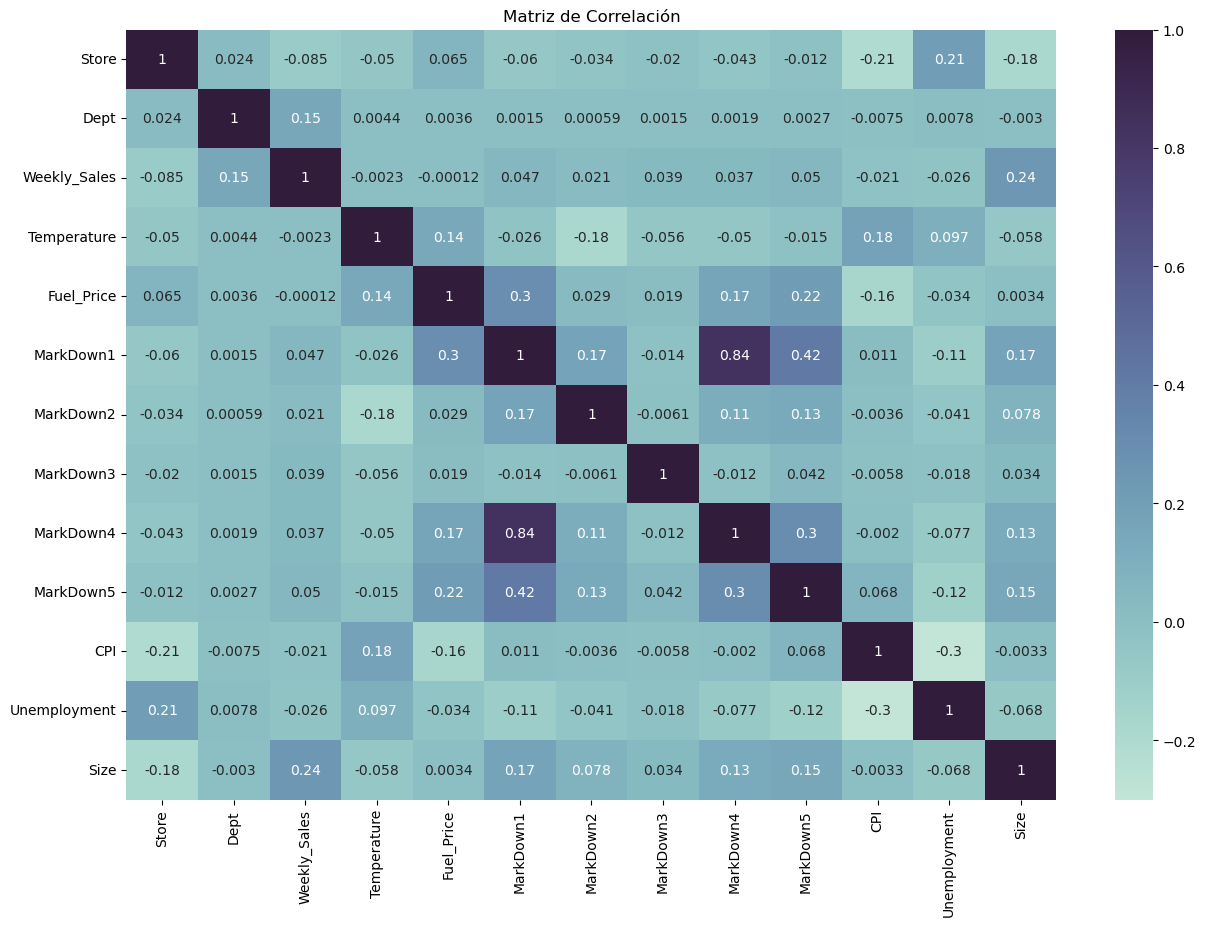

In [12]:
# Crear la paleta Cubehelix
cubehelix_cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
#sns.color_palette("coolwarm", as_cmap=True)

# Matriz de correlación

# Seleccionar solo las columnas numéricas
numeric_columns = ddf.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Crear el heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=cubehelix_cmap)
plt.title('Matriz de Correlación')
plt.show()

In [13]:
# Encontrar las variables más cercanas a 1 y -1
# Lo más cercano a 1 es mayor probabilidad que estas variables afecten de manera positiva la compra, cercano a -1 lo inverso

top_pos_correlations = correlation_matrix[correlation_matrix != 1.0].max().sort_values(ascending=False)[:3]
top_neg_correlations = correlation_matrix[correlation_matrix != -1.0].min().sort_values(ascending=True)[:3]

print("Variables con la mayor correlación positiva:")
print(top_pos_correlations)

print("\nVariables con la mayor correlación negativa:")
print(top_neg_correlations)

Variables con la mayor correlación positiva:
MarkDown1    0.838904
MarkDown4    0.838904
MarkDown5    0.415050
dtype: float64

Variables con la mayor correlación negativa:
CPI            -0.299953
Unemployment   -0.299953
Store          -0.211088
dtype: float64


- a medida de que los valores con correlación positiva aumentan (+1) lo hacen nuestras ventas
- a medida que los valores con correlación negativa aumentan (-1), las ventas disminuyen

# 📈 TSA (Análisis de Serie Temporal)

In [18]:
# preparar el dataset

ts=train.groupby("Date")["Weekly_Sales"].sum()

ts

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

In [19]:
# Ventas Semanales por Año

fig = go.Figure()
years = pd.date_range("2010-01-01", "2013-01-01", freq="AS").tolist()  # Fechas por año
for i in range(len(years) - 1):
    ts_year = ts[years[i]:years[i + 1]]
    
    # Obtener el número de la semana en el año utilizando isocalendar().week
    
    x_values = ts_year.index.to_series().apply(lambda x: x.isocalendar()[1])
    fig.add_trace(
        go.Scatter(
            y=ts_year.values,
            x=x_values,
            name=years[i].year,
        ))

fig.update_layout(
    title="Ventas semanales por año",
    
    xaxis_title="Semanas",
    yaxis_title="Ventas",
    legend_title="Año",
    yaxis_tickprefix='$',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

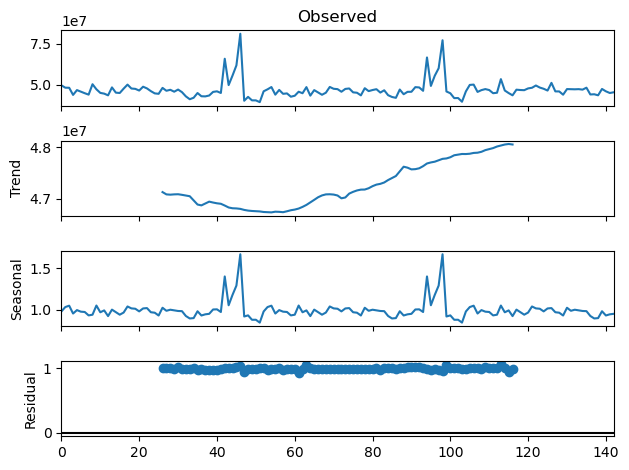

In [20]:
# Descomposición de Serie Tmporal 

res = sm.tsa.seasonal_decompose(ts.values,period=52,model="multiplicative")
res.plot()
plt.show()

- La primer gráfica es la serie temporal
- Trend, en los primeros meses hay poca venta la cual va diminuyendo y aumenta a fines de año
- Seasonal son las ventas por temporada. El dataset cuenta con 2 años enteros, por lo que las seasons son fines de año
- Residual o Ruido es la parte de la serie que no puede ser explicada

## 📌 Características del dataset (Holidays, Temperatura y Precio de la Gasolina)

In [21]:
holidays = train.groupby(["Date"])["IsHoliday"].agg(lambda x: bool(any(x))).sort_index()
fig = px.line(ts, title='Holidays')

for holiday in holidays[holidays].index:
    fig.add_vrect(
        x0=holiday- timedelta(weeks=1) , x1=holiday,
        fillcolor="LightSalmon", opacity=0.7,
        layer="below", line_width=0)

fig.show()

In [22]:
temperature = features.groupby(["Date"])["Temperature"].mean().sort_index()
fig = px.scatter(ts, title='Temperature', color=ts.index.map(lambda x: round(temperature[x])),
                 color_continuous_scale=["blue", "yellow", "red"], labels={"color":"Temperature","value":"total sales"})
fig.update_traces(mode='lines+markers')
fig.update_yaxes(tickprefix="$")
fig.show()

In [23]:
fuel_price = features.groupby(["Date"])["Fuel_Price"].mean().sort_index()
fig = px.scatter(ts, title='Fuel Price', color=ts.index.map(lambda x: round(fuel_price[x],2)),
                 labels={"color":"Fuel Price","value":"total sales"})
fig.update_traces(mode='lines+markers')
fig.update_yaxes(tickprefix="$")
fig.show()

# 📈 Modelos

## 📈 1. SARIMA

- El modelo SARIMA consta de un componente Estacional (S) + un componente Auto Regresivo (AR), integrado (I) con un componente de media móvil (MA)
- Básicamente ve los comportamientos anteriores integrando las inconsistencias, analizado de manera estacional (52 en este caso, pues mis datos son anuales)


- Dickey Fuller debe de ser <0.05, esto significa que nuestra serie temporal pued ser predecida

- Para el componente Auto Regresivo se debe observar el ACF o Autocorrelation Frequency y para la Media Móvil (MA) el PACF ó Autocorrelación Parcial

In [24]:
ts

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

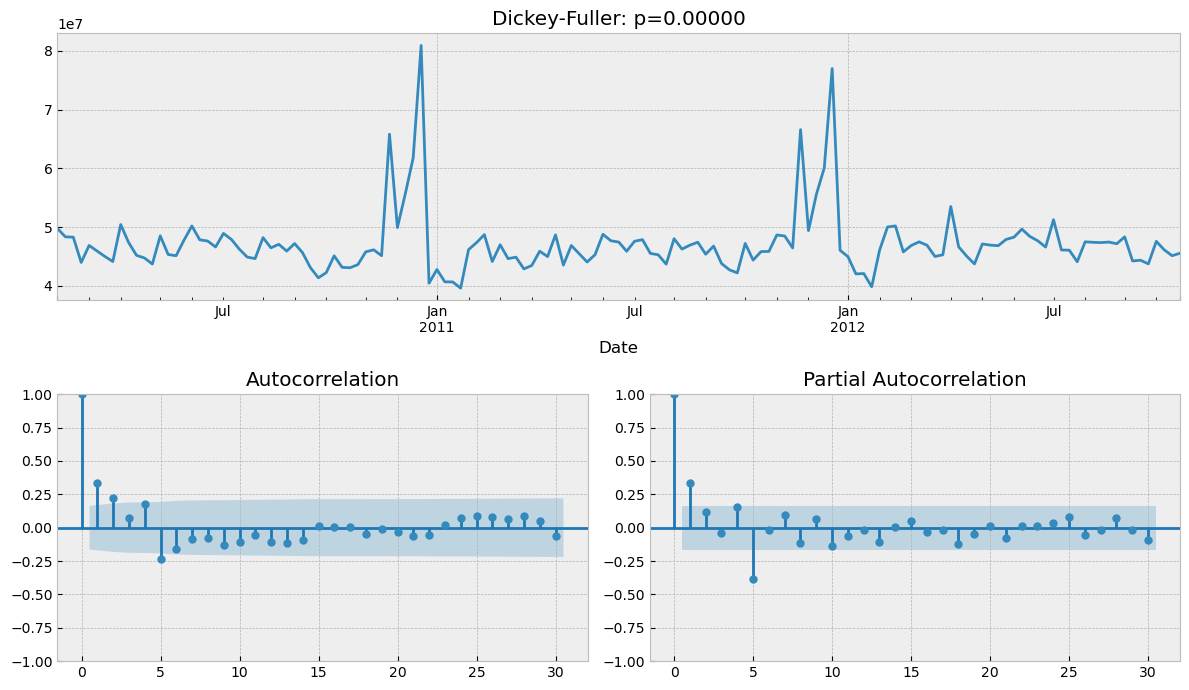

In [27]:
# 1)

def tsplot(ts, lags):
    with plt.style.context("bmh"):    
        fig = plt.figure(figsize=(12, 7))
        
        ts_ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
        acf_ax = plt.subplot2grid((2, 2), (1, 0))
        pacf_ax = plt.subplot2grid((2, 2), (1, 1))
        ts.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(ts)[1]
        ts_ax.set_title('Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(ts, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(ts, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        
tsplot(ts, 30)

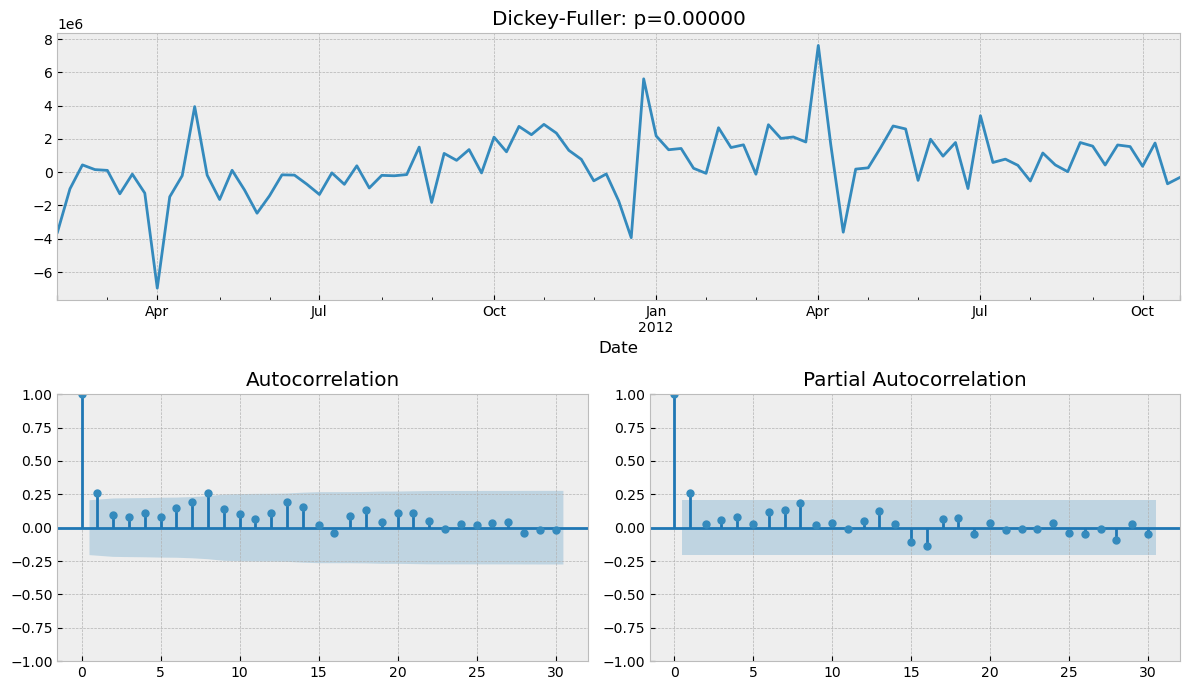

In [28]:
# 2)

# restar fecha actual - 52 semanas (1 año) para ver los patrones que hayo tendencias que puedan haber

ts_diff = ts - ts.shift(52)
tsplot(ts_diff[52:], 30)

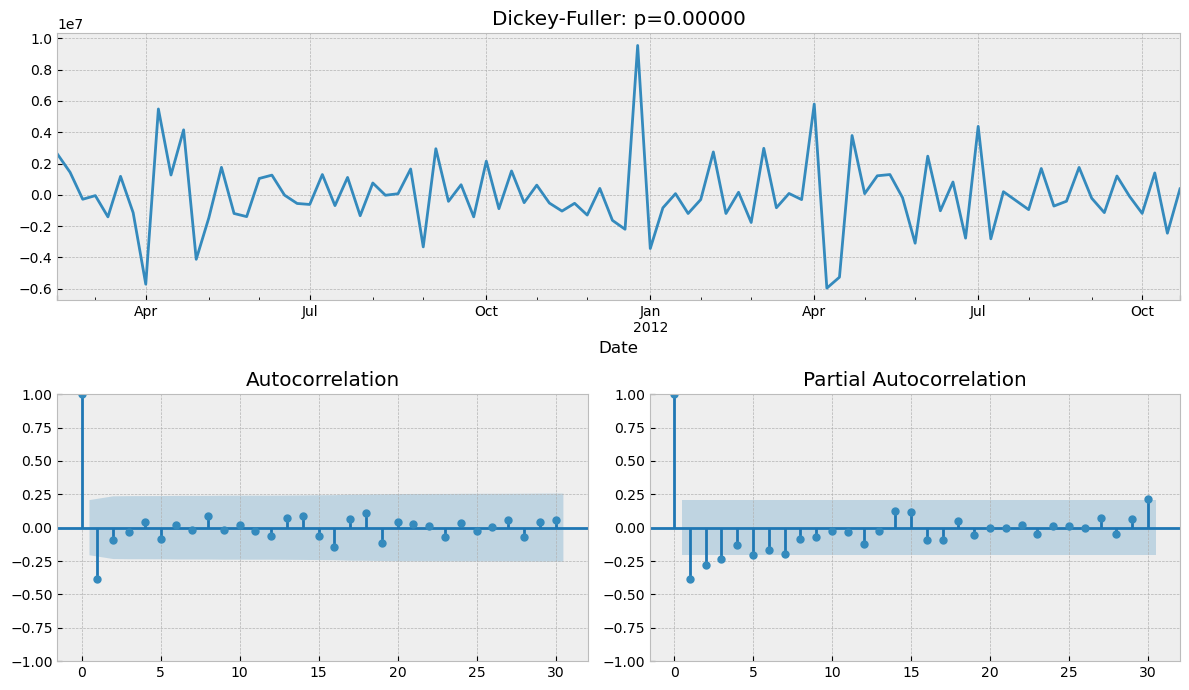

In [29]:
# 3)

# una vez la diferencia valor actual - un año, se ve la variación con 1 periodo / semana anterior para ver su variación
ts_diff = ts_diff - ts_diff.shift(1)

#acf y pacf
tsplot(ts_diff[52+1:], 30) 

In [30]:
# SARIMA
# p escogeremos 2, como visto en el ACF del paso 1
# q escogeremos 3, como visto en el PACF del paso 2
# Se pueden escoger valores p & q diferentes, al final se debe buscar siempre un % en MAE muy bajo

p = 3
d=1 
q = 2

P = 3
D=1 
Q = 2

s = 52


model_Sarima = sm.tsa.statespace.SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(model_Sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 52)   Log Likelihood               -1430.266
Date:                            Tue, 21 May 2024   AIC                           2882.533
Time:                                    08:38:59   BIC                           2910.031
Sample:                                02-05-2010   HQIC                          2893.622
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2106      0.140     -1.507      0.132      -0.484       0.063
ar.L2         -0.9251      0.161   

##  📌 SARIMA Predicciones 

In [31]:
# Medium Average Error (Error Promedio) | Definir la función

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
import plotly.graph_objects as go

def plotSARIMA(ts, model, n_steps):
    
    data = pd.DataFrame(ts)
    data.columns = ['actual']
    data['model_Sarima'] = model_Sarima.fittedvalues
    data['model_Sarima'][:s+d] = np.NaN
    
    forecast = model_Sarima.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = pd.concat([data.model_Sarima, forecast])  
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['model_Sarima'][s+d:])

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data["actual"],
            name="Actual",
        ))
    fig.add_trace(
        go.Scatter(
            x=forecast.index,
            y=forecast,
            name="model_Sarima",
    ))
    
    fig.add_vrect(
    x0=data.index[-1], x1=forecast.index[-1],
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0)
    
    fig.update_layout(
        title=f"Error Absolutio Promedio (MAE): {error:.2f}%",
        xaxis_title="Semanas",
        yaxis_title="Ventas",
        yaxis_tickprefix = '$',
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        ))
    
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

plotSARIMA(ts, model_Sarima, 52)

In [33]:
# Predicciones & dataset original
 

predicciones = model_Sarima.get_prediction(start=0, end=len(ts) - 1)
predicciones_ci = predicciones.conf_int()

# Crear un DataFrame con las predicciones del modelo SARIMA
pred_df = predicciones.predicted_mean.to_frame(name='Predicciones')
pred_df['Intervalo_Inferior'] = predicciones_ci.iloc[:, 0]
pred_df['Intervalo_Superior'] = predicciones_ci.iloc[:, 1]

# Concatenar el DataFrame original (ts) con las predicciones
comparacion_df = pd.concat([ts, pred_df], axis=1)

# Formatear las columnas para evitar la notación científica
pd.options.display.float_format = '{:.2f}'.format  # Establecer el formato

# Imprimir el DataFrame para verificar
comparacion_df


,Weekly_Sales,Predicciones,Intervalo_Inferior,Intervalo_Superior
2010-02-05,49750740.50,0.00,-3928762.57,3928762.57
2010-02-12,48336677.63,42627931.19,38739642.74,46516219.64
2010-02-19,48276993.78,48173400.60,44285218.08,52061583.12
2010-02-26,43968571.13,47309935.04,43422522.68,51197347.39
2010-03-05,46871470.30,45011403.00,41124112.77,48898693.23
...,...,...,...,...
2012-09-28,43734899.40,43979833.91,40250301.00,47709366.82
2012-10-05,47566639.31,47629620.88,43900090.49,51359151.26
2012-10-12,46128514.25,45183750.56,41454228.00,48913273.13
2012-10-19,45122410.57,47203230.09,43473710.98,50932749.20


In [34]:
# Crear una columna "Index" que represente un índice incremental comenzando desde 1
comparacion_df.insert(0, 'Index', range(1, 1 + len(comparacion_df)))

# Crear una columna "Semanas" que represente el número de semanas desde el inicio en formato de fecha
comparacion_df['Semanas'] = pd.date_range(start='2010-02-05', periods=len(comparacion_df), freq='W-FRI')

# Mostrar el DataFrame para verificar
comparacion_df

,Index,Weekly_Sales,Predicciones,Intervalo_Inferior,Intervalo_Superior,Semanas
2010-02-05,1,49750740.50,0.00,-3928762.57,3928762.57,2010-02-05
2010-02-12,2,48336677.63,42627931.19,38739642.74,46516219.64,2010-02-12
2010-02-19,3,48276993.78,48173400.60,44285218.08,52061583.12,2010-02-19
2010-02-26,4,43968571.13,47309935.04,43422522.68,51197347.39,2010-02-26
2010-03-05,5,46871470.30,45011403.00,41124112.77,48898693.23,2010-03-05
...,...,...,...,...,...,...
2012-09-28,139,43734899.40,43979833.91,40250301.00,47709366.82,2012-09-28
2012-10-05,140,47566639.31,47629620.88,43900090.49,51359151.26,2012-10-05
2012-10-12,141,46128514.25,45183750.56,41454228.00,48913273.13,2012-10-12
2012-10-19,142,45122410.57,47203230.09,43473710.98,50932749.20,2012-10-19


In [35]:
# Predicicones (FORECAST)

# Generar el pronóstico para las próximas 20 semanas

forecast = model_Sarima.get_forecast(steps=20 )
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Crear un DataFrame para el forecast

forecast_df = pd.DataFrame({
    'Index': range(len(comparacion_df) + 1, len(comparacion_df) + 1 + len(forecast_mean)),
    
    #'Weekly_Sales': np.zeros(20),  # Inicializar las ventas semanales como 0
    
    'Weekly_Sales': np.nan,
    'Predicciones': forecast_mean,
    'Intervalo_Inferior': forecast_ci.iloc[:, 0],
    'Intervalo_Superior': forecast_ci.iloc[:, 1],
    'Semanas': pd.date_range(start='2012-11-02', periods=20, freq='W-FRI') #aquí se indica que es cada viernes
})

forecast_df

,Index,Weekly_Sales,Predicciones,Intervalo_Inferior,Intervalo_Superior,Semanas
2012-11-02,144,NaN,47603973.78,43874469.50,51333478.06,2012-11-02
2012-11-09,145,NaN,47363642.06,42454929.29,52272354.83,2012-11-09
2012-11-16,146,NaN,45885339.83,40005080.85,51765598.81,2012-11-16
2012-11-23,147,NaN,62002856.26,55324479.84,68681232.69,2012-11-23
2012-11-30,148,NaN,48271484.75,40857758.31,55685211.19,2012-11-30
2012-12-07,149,NaN,53019936.74,44918216.51,61121656.98,2012-12-07
2012-12-14,150,NaN,56785963.27,48068248.71,65503677.83,2012-12-14
2012-12-21,151,NaN,70389961.95,61111541.82,79668382.08,2012-12-21
2012-12-28,152,NaN,45459446.59,35637222.08,55281671.09,2012-12-28
2013-01-04,153,NaN,44523640.43,34174748.63,54872532.22,2013-01-04


In [36]:
# Concatenar los DataFrames forecast_df y comparacion_df
# Reorganizar las columnas en el orden deseado
# Mostrar el nuevo DataFrame reorganizado
# Mostrar el nuevo DataFrame reorganizado


fcstSarima = pd.concat([comparacion_df, forecast_df], ignore_index=True)

column_order = ['Index', 'Semanas', 'Weekly_Sales', 'Predicciones', 'Intervalo_Inferior', 'Intervalo_Superior']
fcstSarima = fcstSarima[column_order]

pd.options.display.float_format = '{:.2f}'.format

fcstSarima

,Index,Semanas,Weekly_Sales,Predicciones,Intervalo_Inferior,Intervalo_Superior
0,1,2010-02-05,49750740.50,0.00,-3928762.57,3928762.57
1,2,2010-02-12,48336677.63,42627931.19,38739642.74,46516219.64
2,3,2010-02-19,48276993.78,48173400.60,44285218.08,52061583.12
3,4,2010-02-26,43968571.13,47309935.04,43422522.68,51197347.39
4,5,2010-03-05,46871470.30,45011403.00,41124112.77,48898693.23
...,...,...,...,...,...,...
158,159,2013-02-15,NaN,49154129.22,36250248.05,62058010.39
159,160,2013-02-22,NaN,45985363.14,32715760.05,59254966.24
160,161,2013-03-01,NaN,46774702.57,33144966.55,60404438.60
161,162,2013-03-08,NaN,47184788.08,33211905.91,61157670.26


In [37]:
# Concatenar los DataFrames forecast_df y comparacion_df
# Reorganizar las columnas en el orden deseado
# Convertir la columna 'Semanas' a tipo datetime 
# Filtrar el DataFrame para incluir solo desde el 6 de enero de 2012 en adelante
# Mostrar el DataFrame filtrado


fcstSarima = pd.concat([comparacion_df, forecast_df], ignore_index=True)

column_order = ['Semanas', 'Weekly_Sales', 'Predicciones', 'Intervalo_Inferior', 'Intervalo_Superior']
fcstSarima = fcstSarima[column_order]

fcstSarima['Semanas'] = pd.to_datetime(fcstSarima['Semanas'])
start_date = pd.to_datetime('2012-01-06')
filtered_fcstSarima = fcstSarima[fcstSarima['Semanas'] >= start_date]
filtered_fcstSarima

,Semanas,Weekly_Sales,Predicciones,Intervalo_Inferior,Intervalo_Superior
100,2012-01-06,44955421.95,47387975.14,43575567.67,51200382.62
101,2012-01-13,42023078.48,43917373.57,40104983.95,47729763.19
102,2012-01-20,42080996.56,42228926.25,38416545.49,46041307.01
103,2012-01-27,39834974.67,42426367.62,38615703.69,46237031.55
104,2012-02-03,46085608.09,46359508.12,42628149.71,50090866.53
...,...,...,...,...,...
158,2013-02-15,NaN,49154129.22,36250248.05,62058010.39
159,2013-02-22,NaN,45985363.14,32715760.05,59254966.24
160,2013-03-01,NaN,46774702.57,33144966.55,60404438.60
161,2013-03-08,NaN,47184788.08,33211905.91,61157670.26


In [33]:
# Exportación de Forecast con SARIMA a un archivo CSV

csv_sarima = filtered_fcstSarima[['Semanas', 'Weekly_Sales', 'Predicciones', 'Intervalo_Inferior', 'Intervalo_Superior']]
csv_sarima.to_csv('FCST__Sarima.csv', index=False)

## 📈 2.Prophet

In [65]:
ts

Date
2010-02-05   49750740.50
2010-02-12   48336677.63
2010-02-19   48276993.78
2010-02-26   43968571.13
2010-03-05   46871470.30
                 ...    
2012-09-28   43734899.40
2012-10-05   47566639.31
2012-10-12   46128514.25
2012-10-19   45122410.57
2012-10-26   45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

In [66]:
prpht_ts = ts.reset_index()
prpht_ts.columns = ["ds","y"]
prpht_ts

,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


In [67]:
# decirle al modelo que hay temporalidad anual

m = Prophet(yearly_seasonality = True)
m.fit(prpht_ts)

08:56:19 - cmdstanpy - INFO - Chain [1] start processing
08:56:19 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
# Ver las siguientes 28 semanas

prpht_fcst = m.make_future_dataframe(periods=28, freq='W')
prpht_fcst

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
166,2013-04-07
167,2013-04-14
168,2013-04-21
169,2013-04-28


In [47]:
# Predict future sales
forecast_prophet = m.predict(prpht_fcst)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,47751041.93,42944342.32,52063316.21
1,2010-02-12,48470741.31,44467118.53,52537852.15
2,2010-02-19,47092845.14,42627416.67,51836224.62
3,2010-02-26,45876783.23,41307512.31,50180565.20
4,2010-03-05,45602668.63,41353126.47,50148908.95
...,...,...,...,...
166,2013-04-07,47922140.50,43727160.88,52358654.02
167,2013-04-14,48322584.11,43926247.51,52959737.92
168,2013-04-21,47467133.10,42977215.73,52006713.11
169,2013-04-28,46155453.68,41603892.65,50593535.93


In [48]:
plot_plotly(m, forecast_prophet)

# 📌 Conclusiones

 - SARIMA da mejores resultados, captura mejor las inconsistencias
- Prophet funciona mejor para predicciones donde no haya tanta variación pues falla en capturar las inconsistencias, en el caso de Retail las ventas aumentan a fin de año de una manera significativa. Por lo que no es óptimo para capturar estas fechas.